Source "train.parquet" and "test.parquet" had been recompressed 
with engine "fastparquet" and compression "gzip". 
Original "pyarrow" with "snappy" crashes Jupyter )(
"fastparquet" with "gzip" properlly works in Jupyter as well, 
as in Google Collab

# Prerequisites

In [ ]:
!pip install --upgrade numpy pandas matplotlib fastparquet nltk sklearn gensim

In [78]:
                                        import re
                                        import numpy
                                        import pandas
from    matplotlib                      import pyplot
                                        import fastparquet
                                        import nltk
from    nltk.corpus                     import stopwords
from    nltk.stem                       import WordNetLemmatizer
from    nltk.tokenize                   import WordPunctTokenizer
from    sklearn.preprocessing           import OneHotEncoder
from    sklearn.feature_extraction.text import TfidfVectorizer
from    sklearn.feature_extraction.text import CountVectorizer
from    gensim.models                   import Word2Vec
from    gensim.models.fasttext          import FastText
from    gensim.models                   import KeyedVectors

In [5]:
# Use this variable to suppress output
DevNull = 0

In [6]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azimut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azimut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
Path = "./"

In [8]:
def ReadParquet(FName):
    return pandas.read_parquet(FName, engine = 'fastparquet')

def SaveParquet(DFrame, FName):
    DFrame.to_parquet(FName, engine = 'fastparquet', compression = 'gzip')

# Reading source data

In [37]:
TestDF = ReadParquet(Path + 'test.parquet').reset_index()
TestDF.shape

(12000, 4)

In [38]:
TestDF.head()

,Id,Body,Tags,Title
0,46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
1,38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
2,44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
3,34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
4,51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


In [39]:
TrainDF = ReadParquet(Path + 'train.parquet').reset_index()
TrainDF.shape

(48000, 5)

In [40]:
TrainDF.head()

,Id,Body,Tags,Title,target
0,34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
1,47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
2,46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
3,45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
4,49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


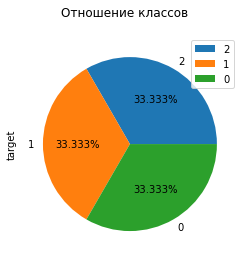

In [41]:
DevNull = TrainDF["target"].value_counts().plot.pie(subplots = True, legend = True, autopct = '%2.3f%%', title = "Отношение классов")

# Preprocessing data

## Removing punctuation and extra spaces

In [42]:
TestDF["Text"] = TestDF.Body + " " + TestDF.Tags + " " + TestDF.Title
TestDF["Text"] = TestDF["Text"].apply(lambda text: re.sub(r'[^(a-zA-Z)\s]', ' ', text))
TestDF["Text"] = TestDF["Text"].apply(lambda text: re.sub('^\s+|\n|\r|\s+$', ' ', text))
TestDF["Text"] = TestDF["Text"].apply(lambda text: re.sub('\ {2,}', ' ', text))
TestDF["Text"][0]

'I was given a decision tree with sample data in class to solve After computing the gaining splitting tree with the sample data provided I ended up with the same tree that was in the question What does that mean Can someone explain what happened there math machine learning artificial intelligence decision tree entropy Desecion trees ended up with same given tree after gain split computation '

In [43]:
TrainDF["Text"] = TrainDF.Body + " " + TrainDF.Tags + " " + TrainDF.Title
TrainDF["Text"] = TrainDF["Text"].apply(lambda text: re.sub(r'[^(a-zA-Z)\s]', ' ', text))
TrainDF["Text"] = TrainDF["Text"].apply(lambda text: re.sub('^\s+|\n|\r|\s+$', ' ', text))
TrainDF["Text"] = TrainDF["Text"].apply(lambda text: re.sub('\ {2,}', ' ', text))
TrainDF["Text"][0]

'Algorithmm input Graph G output Set of MSTs T begin T null E G Edges for all vertices in G Create a tree t having single vertex b add t to T end for repeat Find an edge e E having minimum weight such that one end belongs to t T and the other end does not belongs to any of the trees in T Add e to t until e NULL I m stuck on the logic for the highlighted block I ve used simple objects for vertex edge and tree And for their sets used array of Objects java algorithm graph algorithm I am implementing a Minimum Spanning Forrest algorihm in java But stuck on how to write a loop'

## Checking for invalid values (NA and Null)

In [44]:
print("TestDF:")
print(" ID:")
print("  NA = " + str(TestDF["Id"].isna().sum()))
print("  Null = " + str(TestDF["Id"].isnull().sum()))

TestDF:
 ID:
  NA = 0
  Null = 0


In [45]:
print("TrainDF:")
print(" ID:")
print("  NA = " + str(TrainDF["Id"].isna().sum()))
print("  Null = " + str(TrainDF["Id"].isnull().sum()))
print(" target:")
print("  NA = " + str(TrainDF["target"].isna().sum()))
print("  Null = " + str(TrainDF["target"].isnull().sum()))

TrainDF:
 ID:
  NA = 0
  Null = 0
 target:
  NA = 0
  Null = 0


No invalid values :)

## Tokenizing

In [46]:
Tokenizer = WordPunctTokenizer()
TestDF["Text"] = TestDF["Text"].apply(lambda text: Tokenizer.tokenize(text.lower()))
TestDF["Text"].head()

0    [i, was, given, a, decision, tree, with, sampl...
1    [p, i, am, moving, a, test, application, over,...
2    [p, i, would, like, to, be, able, to, perform,...
3    [p, i, m, using, a, href, https, github, com, ...
4    [i, have, some, test, cases, and, i, want, the...
Name: Text, dtype: object

In [47]:
TrainDF["Text"] = TrainDF["Text"].apply(lambda text: Tokenizer.tokenize(text.lower()))
TrainDF["Text"].head()

0    [algorithmm, input, graph, g, output, set, of,...
1    [while, converting, the, data, frame, to, html...
2    [p, this, should, be, an, easy, one, but, some...
3    [p, let, say, i, have, a, component, in, angul...
4    [p, i, m, setting, a, var, using, code, set, t...
Name: Text, dtype: object

## Counting and removing stop words

In [48]:
# Length of word must be greater than "2". No explanation, just intuition :)
def GetStopwords(text):
    StopWords = []
    for w in text:
        if (w in stopwords.words("english")) or (len(w) <= 2):
            StopWords.append(w)
    return StopWords

def RemoveStopwords(text):
    PureWords = []
    for w in text:
        if w not in stopwords.words("english") and len(w) > 2:
            PureWords.append(w)
    return PureWords

In [49]:
TestDF["Stop"] = TestDF["Text"].apply(GetStopwords)
TestDF["NumOfStopwords"] = TestDF["Stop"].apply(lambda text: len(text))
TestDF["Text"] = TestDF["Text"].apply(RemoveStopwords)
TestDF.head()

,Id,Body,Tags,Title,Text,Stop,NumOfStopwords
0,46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...,"[given, decision, tree, sample, data, class, s...","[i, was, a, with, in, to, after, the, with, th...",29
1,38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code',"[moving, test, application, xcode, beta, conve...","[p, i, am, a, over, to, and, my, to, i, am, wi...",37
2,44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...,"[would, like, able, perform, linting, jenkins,...","[p, i, to, be, to, on, and, it, that, is, not,...",24
3,34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...,"[using, href, https, github, com, ftlabs, fast...","[p, i, m, a, a, on, a, with, because, i, to, t...",66
4,51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?,"[test, cases, want, keep, running, times, orde...","[i, have, some, and, i, them, to, for, in, how...",22


In [ ]:
TrainDF["Stop"] = TrainDF["Text"].apply(GetStopwords)
TrainDF["NumOfStopwords"] = TrainDF["Stop"].apply(lambda text: len(text))
TrainDF["Text"] = TrainDF["Text"].apply(RemoveStopwords)
TrainDF.head()

## Lemmatization

In [50]:
def Lemmatize(text):
    Lemmatizer = WordNetLemmatizer()
    Words = []
    for w in text:
        Words.append(Lemmatizer.lemmatize(w))
    return Words

TestDF["Text"] = TestDF["Text"].apply(Lemmatize)
TrainDF["Text"] = TrainDF["Text"].apply(Lemmatize)

# Extra features

In [51]:
# Number of tags
TestDF["NumOfTags"] = TestDF["Tags"].apply(lambda text: len(re.findall('<', text)))
TrainDF["NumOfTags"] = TrainDF["Tags"].apply(lambda text: len(re.findall('<', text)))

In [52]:
# Number of words
TestDF["NumOfWords"] = TestDF["Text"].apply(lambda text: len(text))
TrainDF["NumOfWords"] = TrainDF["Text"].apply(lambda text: len(text))

In [53]:
# Number of letters
def NumberOfLetters(text):
    counter = 0
    for w in text:
        counter += len(w)
    return counter

TestDF["NumOfLetters"] = TestDF["Text"].apply(NumberOfLetters)
TrainDF["NumOfLetters"] = TrainDF["Text"].apply(NumberOfLetters)

In [74]:
def MakeFullText(text):
    string = ""
    for w in text:
        string += w + " "
    return string

In [75]:
TestDF["FullText"] = TestDF["Text"].apply(MakeFullText)
TrainDF["FullText"] = TrainDF["Text"].apply(MakeFullText)

In [76]:
SaveParquet(TestDF, Path + "test.preprocessed.parquet")
SaveParquet(TrainDF, Path + "train.preprocessed.parquet")

# One Hot Encoding

In [ ]:
# Load preprocessed data frames
# TestDF = ReadParquet(Path + "test.preprocessed.parquet")
# TrainDF = ReadParquet(Path + "train.preprocessed.parquet")

In [ ]:
# Я, если честно, понимая, насколько огромным получится словарь, 
# не стал насиловать свои 8Gb RAM и 12Gb RAM Collab'а.

# Word2Vec

In [9]:
# Load preprocessed data frames
# TestDF = ReadParquet(Path + "test.preprocessed.parquet")
# TrainDF = ReadParquet(Path + "train.preprocessed.parquet")

In [11]:
W2V_OurModel = Word2Vec(TrainDF["Text"].values, min_count = 1, size = 100, window = 5)
# W2V_OurModel.wv.save(Path + 'W2V_OurModel.model')

In [95]:
def ConvertTextIntoVec(text, model):
    arr = []
    for w in text:
        try:
            arr.append(model.wv.get_vector(w))
        except:
            continue
    return arr

In [23]:
Test_W2V_Our = pandas.DataFrame(columns = ['W2V Our'])
Train_W2V_Our = pandas.DataFrame(columns = ['W2V Our'])
Test_W2V_Our["W2V Our"] = TestDF["Text"].apply(ConvertTextIntoVec, args = [W2V_OurModel])
Train_W2V_Our["W2V Our"] = TrainDF["Text"].apply(ConvertTextIntoVec, args = [W2V_OurModel])

In [94]:
# Loading pretrained model
W2V_PreModel = KeyedVectors.load_word2vec_format(Path + "W2V-GoogleNews-vectors-negative300.bin", binary = True)

In [97]:
Test_W2V_Pre = pandas.DataFrame(columns = ['W2V Pre'])
Train_W2V_Pre = pandas.DataFrame(columns = ['W2V Pre'])
Test_W2V_Pre["W2V Pre"] = TestDF["Text"].apply(ConvertTextIntoVec, args = [W2V_PreModel])
Train_W2V_Pre["W2V Pre"] = TrainDF["Text"].apply(ConvertTextIntoVec, args = [W2V_PreModel])

<ipython-input-95-4de70f88808d>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  arr.append(model.wv.get_vector(w))


# Fasttext

In [ ]:
# Load preprocessed data frames
# TestDF = ReadParquet(Path + "test.preprocessed.parquet")
# TrainDF = ReadParquet(Path + "train.preprocessed.parquet")

In [81]:
FT = FastText(size = 4, window = 5, min_count = 1)
FT.build_vocab(sentences = TrainDF["FullText"].tolist())

In [82]:
FT.train(sentences = TrainDF["FullText"].tolist(), epochs = FT.epochs, 
         total_examples = FT.corpus_count, total_words = FT.corpus_total_words)

In [85]:
Test_FT = pandas.DataFrame(columns = ['Fasttext'])
Train_FT = pandas.DataFrame(columns = ['Fasttext'])
Test_FT["Fasttext"] = TestDF["Text"].apply(ConvertTextIntoVec, args = [FT])
Train_FT["Fasttext"] = TrainDF["Text"].apply(ConvertTextIntoVec, args = [FT])

In [ ]:
# Loading pretrained model
# FT_Pre = FastText.load_fasttext_format(Path + 'fasttext-wiki.en.bin')
# 8Гб оперативки вышли из чата

<ipython-input-100-122e679cee45>:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  FT_Pre = FastText.load_fasttext_format(Path + 'fasttext-wiki.en.bin')


In [ ]:
# Test_FT_Pre = pandas.DataFrame(columns = ['Fasttext Pre'])
# Train_FT_Pre = pandas.DataFrame(columns = ['Fasttext Pre'])
# Test_FT_Pre["Fasttext Pre"] = TestDF["Text"].apply(ConvertTextIntoVec, args = [FT_Pre])
# Train_FT_Pre["Fasttext Pre"] = TrainDF["Text"].apply(ConvertTextIntoVec, args = [FT_Pre])

# Bag of Words

In [ ]:
# Load preprocessed data frames
# TestDF = ReadParquet(Path + "test.preprocessed.parquet")
# TrainDF = ReadParquet(Path + "train.preprocessed.parquet")

In [69]:
BOW = CountVectorizer()
Test_BOW = BOW.fit_transform(TestDF["FullText"])
Train_BOW = BOW.fit_transform(TrainDF["FullText"])

# TF-IDF

In [58]:
# Load preprocessed data frames
# TestDF = ReadParquet(Path + "test.preprocessed.parquet")
# TrainDF = ReadParquet(Path + "train.preprocessed.parquet")

In [70]:
TF_IDF = TfidfVectorizer()
Test_TDIDF = TF_IDF.fit_transform(TestDF["FullText"])
Train_TDIDF = TF_IDF.fit_transform(TrainDF["FullText"])